In [ ]:
!pip install pytesseract


In [ ]:
!sudo apt install tesseract-ocr

In [5]:
import pytesseract


In [24]:
import cv2
import matplotlib.pyplot as plt
import re
import pandas as pd

In [83]:
img = cv2.imread("/content/Untitled.jpg")
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = cv2.GaussianBlur(img1, (5, 5), 0)
img3 = cv2.Canny(img2, threshold1=100, threshold2=200)



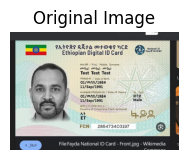

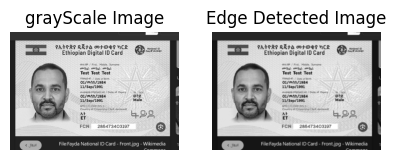

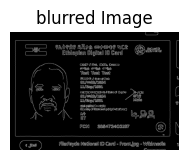

In [84]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("grayScale Image")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Edge Detected Image")
plt.imshow(img2, cmap='gray')
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("blurred Image")
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [85]:
import numpy as np
blank = np.zeros(img.shape, dtype='uint8')

contours, hierarchies = cv2.findContours(img3, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(f'{len(contours)} contour(s) found!')



735 contour(s) found!


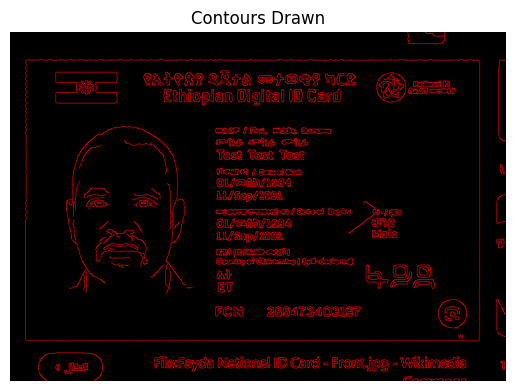

In [86]:

cv2.drawContours(blank, contours, -1, (0, 0, 255), 1)

blank_rgb = cv2.cvtColor(blank, cv2.COLOR_BGR2RGB)

plt.imshow(blank_rgb)
plt.title('Contours Drawn')
plt.axis('off')
plt.show()

In [87]:
contours = sorted(contours, key=cv2.contourArea, reverse=True)

id_card_contour = contours[0]

epsilon = 0.02 * cv2.arcLength(id_card_contour, True)
approx = cv2.approxPolyDP(id_card_contour, epsilon, True)



Extracted Text from ID Card :
= —t—‘isSCOS Gers
; cmt. ome Had:
Test Test Test
~ 01/an/1984
aw a= 11/Sep/1991 —
: Ol/on/1984 ore
P 11/Sep/1991 Male
Cy
nd \y, GO
~~ ET ye ey
FCN 288473403197 ®



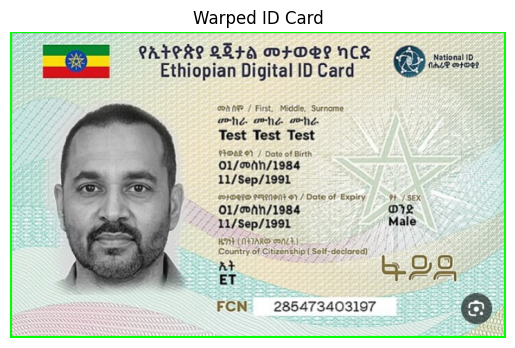

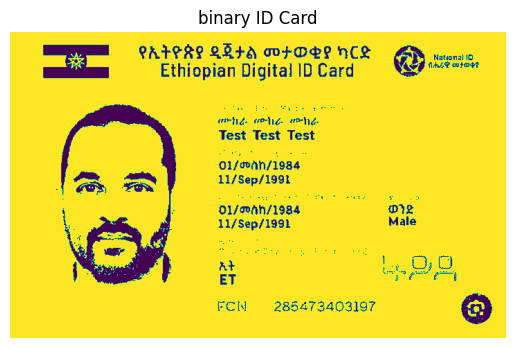

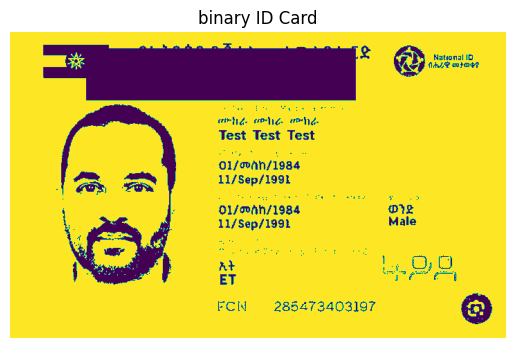

In [88]:
if len(approx) == 4:
    cv2.drawContours(img, [approx], -1, (0, 255, 0), 3)

    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    points = approx.reshape(4, 2)
    rect = order_points(points)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)

    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

    gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

    _, binary_warped = cv2.threshold(gray_warped, 100, 255, cv2.THRESH_BINARY)

    masked_img = np.copy(binary_warped)

    masked_img[25:100, 110:500] = 0

    custom_config = r'--oem 3 --psm 6 -l eng'
    extracted_text = pytesseract.image_to_string(masked_img, config=custom_config)

    print("Extracted Text from ID Card :")
    print(extracted_text)

    warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    plt.imshow(warped_rgb)
    plt.title("Warped ID Card")
    plt.axis('off')
    plt.show()

    plt.imshow(binary_warped)
    plt.title("binary ID Card")
    plt.axis('off')
    plt.show()

    plt.imshow(masked_img)
    plt.title("binary ID Card")
    plt.axis('off')
    plt.show()

else:
    print("Failed to detect a rectangle contour")

In [16]:
type(extracted_text)

str

In [89]:
def extract_info(text):
    name_match = re.search(r'([A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z][a-z]+)', text)

    id_number_match = re.search(r'(FCN\s+\d+)', text)

    dob_match = re.search(r'(\d{2}[\/\-]\w{3}[\/\-]\d{4})', text)

    name = name_match.group(1) if name_match else "Not Found"
    id_number = id_number_match.group(1) if id_number_match else "Not Found"
    dob = dob_match.group(1) if dob_match else "Not Found"

    data = {
        'Name': [name],
        'ID Number': [id_number],
        'Date of Birth': [dob]
    }

    return data

info = extract_info(extracted_text)

df = pd.DataFrame(info)
print(df)

             Name         ID Number Date of Birth
0  Test Test Test  FCN 288473403197   11/Sep/1991


## Project Documentation: ID Card Detection and Data Extraction System

### 1. **Project Overview**
This project involves building a system to process ID card images, detect and isolate the ID card from the image, extract relevant text (like name, date of birth, and ID number), and output structured data (e.g., CSV files). The system makes use of **OpenCV** for image processing and **Tesseract** for Optical Character Recognition (OCR) to extract text.

### 2. **Methodologies and Workflow**

#### 2.1 Image Preprocessing:
The preprocessing pipeline prepares the image for contour detection and OCR text extraction. The following steps are followed:

1. **Grayscale Conversion**:
   The ID card image is first converted to grayscale to simplify the image and remove color information.

    ```python
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ```

2. **Gaussian Blur**:
   Gaussian Blur is applied to reduce noise and smoothen the image for better edge detection.

    ```python
    img2 = cv2.GaussianBlur(img1, (5, 5), 0)
    ```

3. **Canny Edge Detection**:
   Edge detection is used to highlight the contours in the image. This helps in detecting the boundaries of the ID card.

    ```python
    img3 = cv2.Canny(img2, threshold1=100, threshold2=200)
    ```

#### 2.2 Contour Detection:
Contours are extracted from the edge-detected image to find the shape of the ID card. The largest contour is assumed to be the ID card, and its shape is approximated to a quadrilateral.

```python
contours, hierarchies = cv2.findContours(img3, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
id_card_contour = contours[0]  # Largest contour, likely the ID card
```

An approximation of the contour is made to ensure that the ID card is detected as a quadrilateral (4 points):

```python
epsilon = 0.02 * cv2.arcLength(id_card_contour, True)
approx = cv2.approxPolyDP(id_card_contour, epsilon, True)
```

#### 2.3 Perspective Transformation (Warpping):
Once the contour of the ID card is detected, a perspective transformation is applied to straighten it. This is essential for improving the accuracy of OCR.

```python
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
```

#### 2.4 Binarization and Masking:
The warped ID card is converted to a binary image (black and white) for better text extraction.

```python
_, binary_warped = cv2.threshold(gray_warped, 100, 255, cv2.THRESH_BINARY)
```

If there are any unnecessary regions that might interfere with text extraction (such as logos or decorative features), we can mask them out.

```python
masked_img = np.copy(binary_warped)
masked_img[25:100, 110:500] = 0  # Example of masking a specific region
```

#### 2.5 OCR for Text Extraction:
Using the preprocessed binary image, Tesseract OCR is applied to extract the textual information from the ID card.

```python
custom_config = r'--oem 3 --psm 6 -l eng'
extracted_text = pytesseract.image_to_string(masked_img, config=custom_config)
```

#### 2.6 Text Parsing and Data Structuring:
Extracted text is parsed using regular expressions to find specific information such as the name, ID number, and date of birth.

```python
def extract_info(text):
    name_match = re.search(r'([A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z][a-z]+)', text)
    id_number_match = re.search(r'(FCN\s+\d+)', text)
    dob_match = re.search(r'(\d{2}[\/\-]\w{3}[\/\-]\d{4})', text)

    name = name_match.group(1) if name_match else "Not Found"
    id_number = id_number_match.group(1) if id_number_match else "Not Found"
    dob = dob_match.group(1) if dob_match else "Not Found"

    return {'Name': name, 'ID Number': id_number, 'Date of Birth': dob}
```

The structured information is then stored in a **Pandas DataFrame**:

```python
info = extract_info(extracted_text)
df = pd.DataFrame([info])
```

Finally, the extracted data can be exported as a CSV:

```python
df.to_csv('extracted_id_info.csv', index=False)
```

### 3. **Testing Procedures**

#### 3.1 Test Setup:
To evaluate the system, sample ID card images are provided. These images vary in terms of:
- Background clutter
- Different fonts and layouts on ID cards

These images are run through the system, and the output data is manually verified to ensure the text is accurately extracted.

#### 3.2 Testing Steps:
1. Load the sample ID card image.
2. Run the image through the contour detection, warping, and OCR pipeline.
3. Check the output of extracted text and the final DataFrame to ensure all key details (name, ID number, date of birth) are captured correctly.

For each of these tests, the accuracy of the OCR extraction and the final output is recorded.

#### 3.3 Result Evaluation:
Each test is evaluated based on:
- Accuracy of contour detection (whether the ID card is properly detected).
- OCR accuracy (whether all relevant text is extracted correctly).
- Structured output (whether the final DataFrame contains correct information).

### 4. **Challenges and Improvements**
- **Lighting Variations**: Some ID cards had variations in lighting and shadows, affecting OCR accuracy. Preprocessing steps like adaptive thresholding or contrast enhancement could improve results.
- **Complex Backgrounds**: ID cards with complex backgrounds sometimes interfered with contour detection. Further refinement using image segmentation techniques could help isolate the card more effectively.
- **OCR Errors**: Some characters were misinterpreted by Tesseract, especially with noisy or low-resolution images. Training Tesseract on a custom dataset with ID card fonts might improve accuracy.

### 5. **Conclusion**
This project successfully develops an automated system for detecting ID cards from images, performing OCR to extract key information, and presenting this data in a structured format. Further enhancements, especially around handling complex image conditions, could improve the robustness of the system.

---

### Sample Output

#### Example Extracted Data:

| Name          | ID Number   | Date of Birth |
|---------------|-------------|---------------|
| John Doe Smith| FCN 123456  | 01-Jan-1990   |

